In [1]:
import pandas as pd
import re
import numpy as np
import torch
import seaborn as sns

from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from math import sqrt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from IPython.display import clear_output

%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')


In [2]:
# Setting seed for reproducibility

torch.manual_seed(16)

In [3]:
# Getting our data

df_comms = pd.read_csv("data/comments.csv")
df_posts = pd.read_csv("data/posts.csv")

In [4]:
df_merged = pd.concat(
    [
        df_comms[["comment_text", "comment_category"]].rename(
            columns={"comment_text": "text", "comment_category": "target"}
        ),
        df_posts[["post_text", "post_category"]].rename(
            columns={"post_text": "text", "post_category": "target"}
        ),
    ],
    axis=0,
)

In [5]:
df_merged


,text,target
0,"Добрый вечер подскажите пожалуйста,как будут п...",u
1,"[id163680619|Елена], нет, без регистрации же к...",o
2,Браво Рахмон !\nБраво ПЕШВОИ МИЛЛАТ!,o
3,"[id124559480|Яна], спасибо",u
4,"[id222093963|Джамал], Ага 😄 тогда будьте счаст...",u
...,...,...
25414,Добрый день!\nПодскажите график работы кабинет...,u
25415,Добрый день.\nПодскажите пожалуйста кто знает....,o
25416,"Добрый вечер! Подскажите, пожалуйста, кто знае...",u
25417,"Добрый день! Подскажите, я гражданин Казахстан...",u


In [6]:
# Cleaning data from unknown labels

df_merged = df_merged[df_merged["target"] != "u"]
df_merged.reset_index(drop=True, inplace=True)

In [7]:
df_merged


,text,target
0,"[id163680619|Елена], нет, без регистрации же к...",o
1,Браво Рахмон !\nБраво ПЕШВОИ МИЛЛАТ!,o
2,"[id434862366|Виталий], можно самому, можно чер...",o
3,"[id72025982|Сергей], а про растаможку не может...",o
4,"[id140939457|Вера], спасибо. Хорошо что все за...",o
...,...,...
131528,"Воистину, верующие - братья. Посему примиряйте...",o
131529,приятного аппетита время сухура,o
131530,"Добрый день всем. Кто подскажет, где и как про...",o
131531,| 23.12.2019 | На днях в Facebook появилась фо...,o


In [8]:
# Tokenizing with simple regex

def process_text(text):
    words = re.findall("[a-яА-ЯёЁ]+", text.lower())

    return words

In [9]:
df_merged["clean_text"] = df_merged["text"].apply(lambda x: process_text(x))

C:\Users\al_po\AppData\Local\Temp\ipykernel_7620\993328078.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged["clean_text"] = df_merged["text"].apply(lambda x: process_text(x))


In [10]:
# Getting word frequency duct for embs

word2freq = {}
lengths = []

for text in tqdm(df_merged["clean_text"]):
    words = text

    lengths.append(len(words))

    for word in words:
        if word in word2freq:
            word2freq[word] += 1
        else:
            word2freq[word] = 1

  0%|          | 0/131533 [00:00<?, ?it/s]

In [11]:
# Creating lookup table

word2index = {"PAD": 0}
vectors = []

word2vec_file = open("embs/cc.ru.300.vec")

n_words, embedding_dim = word2vec_file.readline().split()
n_words, embedding_dim = int(n_words), int(embedding_dim)

# Zero vector for PAD
vectors.append(np.zeros((1, embedding_dim)))

progress_bar = tqdm(desc="Read word2vec", total=n_words)

while True:
    line = word2vec_file.readline().strip()

    if not line:
        break

    current_parts = line.split()

    current_word = " ".join(current_parts[:-embedding_dim])

    if current_word in word2freq:
        word2index[current_word] = len(word2index)

        current_vectors = current_parts[-embedding_dim:]
        current_vectors = np.array(list(map(float, current_vectors)))
        current_vectors = np.expand_dims(current_vectors, 0)

        vectors.append(current_vectors)

    progress_bar.update(1)

progress_bar.close()

word2vec_file.close()

vectors = np.concatenate(vectors)

Read word2vec:   0%|          | 0/2000000 [00:00<?, ?it/s]

In [12]:
# Mapping categorical values

cat_mapper = {cat: n for n, cat in enumerate(df_merged["target"].unique())}
df_merged["target"] = df_merged["target"].map(cat_mapper)

C:\Users\al_po\AppData\Local\Temp\ipykernel_7620\3819259165.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged["target"] = df_merged["target"].map(cat_mapper)


In [13]:
cat_mapper


{'o': 0, 'l': 1, 'w': 2}

In [14]:
# Dataset is unbalanced

df_merged["target"].value_counts()

0    124149
2      3911
1      3473
Name: target, dtype: int64

In [15]:
# Let's use undersampling technic to rebalance data

df_merged = df_merged.sort_values(by=["target"], ascending=False)[:13000]

In [16]:
# Creating torch Dataset 

class WordData(Dataset):
    def __init__(
        self,
        x_data,
        y_data,
        word2index,
        sequence_length=128,
        pad_token="PAD",
        verbose=True,
    ):
        super().__init__()

        self.x_data = []
        self.y_data = y_data

        self.word2index = word2index
        self.sequence_length = sequence_length

        self.pad_token = pad_token
        self.pad_index = self.word2index[self.pad_token]

        self.load(x_data, verbose=verbose)

    @staticmethod
    def process_text(text):
        words = re.findall("[a-яА-ЯеЁ]+", text.lower())
        return words

    def load(self, data, verbose=True):
        data_iterator = tqdm(data, desc="Loading data", disable=not verbose)

        for text in data_iterator:
            words = self.process_text(text)

            indexed_words = self.indexing(words)

            self.x_data.append(indexed_words)

    def indexing(self, tokenized_text):
        return [
            self.word2index[word] for word in tokenized_text if word in self.word2index
        ]

    def padding(self, sequence):
        if len(sequence) < self.sequence_length:
            add_pad = self.sequence_length - len(sequence)
            return sequence + [self.pad_index] * add_pad
        else:
            return sequence[: self.sequence_length]

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = self.x_data[idx]
        x = self.padding(x)
        x = torch.Tensor(x).long()

        y = self.y_data[idx]

        return x, y

In [17]:
# Splitting data into test and train

x_train, x_val, y_train, y_val = train_test_split(
    df_merged.text, df_merged.target, test_size=0.2
)

train_dataset = WordData(list(x_train), list(y_train), word2index)
train_loader = DataLoader(train_dataset, batch_size=64)

validation_dataset = WordData(list(x_val), list(y_val), word2index)
validation_loader = DataLoader(validation_dataset, batch_size=64)

Loading data:   0%|          | 0/10400 [00:00<?, ?it/s]

Loading data:   0%|          | 0/2600 [00:00<?, ?it/s]

In [18]:
# We will combine RNN, CNN and attention

In [19]:
class model_with_att(torch.nn.Module):
    def __init__(self, matrix_w, n, embedding_dim=300):
        super().__init__()

        self.n = n
        self.embedding_dim = embedding_dim
        self.emb_layer = torch.nn.Embedding.from_pretrained(
            torch.Tensor(matrix_w)
        )  # 64 128 300

        self.LSTM = torch.nn.LSTM(
            300, 512, batch_first=True, num_layers=2, dropout=0.2, bidirectional=True
        )
        self.q_proj = torch.nn.Linear(in_features=512 * 2, out_features=512, bias=True)
        self.k_proj = torch.nn.Linear(in_features=512 * 2, out_features=512, bias=True)
        self.v_proj = torch.nn.Linear(in_features=512 * 2, out_features=512, bias=True)

        self.att_soft = torch.nn.Softmax(dim=2)

        self.cnn_3gr = torch.nn.Conv1d(in_channels=512, out_channels=64, kernel_size=3)
        self.cnn_4gr = torch.nn.Conv1d(in_channels=512, out_channels=64, kernel_size=4)
        self.cnn_5gr = torch.nn.Conv1d(in_channels=512, out_channels=64, kernel_size=5)

        self.linear_1 = torch.nn.Linear(
            in_features=64 * 3, out_features=1024, bias=True
        )
        self.relu = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(1024, out_features=n, bias=True)

    def forward(self, x):
        x_emb = self.emb_layer(x)
        x, _ = self.LSTM(x_emb)

        x_q = self.q_proj(x)
        x_k = self.k_proj(x)
        x_v = self.v_proj(x)

        att_scores = torch.bmm(x_q, x_k.transpose(2, 1)) / np.sqrt(embedding_dim)
        att_dist = self.att_soft(att_scores)
        attention_vectors = torch.bmm(att_dist, x_v)

        x_att = attention_vectors.transpose(2, 1)

        x_cnn3 = self.cnn_3gr(x_att)
        x_cnn4 = self.cnn_4gr(x_att)
        x_cnn5 = self.cnn_5gr(x_att)

        frst, _ = x_cnn3.max(
            dim=-1,
        )
        sc, _ = x_cnn4.max(
            dim=-1,
        )
        thr, _ = x_cnn5.max(
            dim=-1,
        )

        x_cat = torch.cat((frst, sc, thr), dim=-1)

        x = self.linear_1(x_cat)
        x = self.relu(x)
        x = self.linear_2(x)

        return x

In [20]:
# model_with_att(
#   (emb_layer): Embedding(95936, 300)
#   (LSTM): LSTM(300, 512, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
#   (q_proj): Linear(in_features=1024, out_features=512, bias=True)
#   (k_proj): Linear(in_features=1024, out_features=512, bias=True)
#   (v_proj): Linear(in_features=1024, out_features=512, bias=True)
#   (att_soft): Softmax(dim=2)
#   (cnn_3gr): Conv1d(512, 64, kernel_size=(3,), stride=(1,))
#   (cnn_4gr): Conv1d(512, 64, kernel_size=(4,), stride=(1,))
#   (cnn_5gr): Conv1d(512, 64, kernel_size=(5,), stride=(1,))
#   (linear_1): Linear(in_features=192, out_features=1024, bias=True)
#   (relu): ReLU()
#   (linear_2): Linear(in_features=1024, out_features=3, bias=True)
# )

In [21]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [22]:
# Defining train and val funcs

def train_loop(train_loader, model, optimizer, criterion):
    model.train()

    train_losses = []

    for x, y in tqdm(train_loader):
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        pred = model(x)
        loss = criterion(pred, y)

        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    return train_losses


def val_loop(val_loader, model, optimizer, criterion):
    model.eval()

    test_targets = []
    test_pred_class = []
    test_losses = []

    with torch.inference_mode():
        for x, y in tqdm(val_loader):
            x = x.to(device)
            pred = model(x)
            pred = pred.cpu()

            test_targets.append(y.numpy())
            test_pred_class.append(np.argmax(pred, axis=1))

            loss = criterion(pred, y)

            test_losses.append(loss.item())

    return test_losses, test_targets, test_pred_class


def train(train_loader, val_loader, model, optimizer, criterion, epochs):
    train_losses = []
    test_losses = []
    f1_scores = []

    for epoch in range(epochs):
        train_loss = train_loop(train_loader, model, optimizer, criterion)
        test_loss, test_targets, test_pred_class = val_loop(
            val_loader, model, optimizer, criterion
        )

        test_targets = np.concatenate(test_targets).squeeze()
        test_pred_class = np.concatenate(test_pred_class).squeeze()

        f1 = f1_score(test_targets, test_pred_class, average="macro")

        train_losses.append(np.mean(train_loss))
        test_losses.append(np.mean(test_loss))
        f1_scores.append(f1)

        clear_output(True)
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
        ax[0].plot(train_losses, label="train loss")
        ax[0].plot(test_losses, label="val loss")
        ax[0].set_xlabel("Epoch")
        ax[0].set_title("Losses")
        ax[1].plot(f1_scores, label="F1 test")
        ax[1].set_xlabel("Epoch")
        ax[1].set_title("F1 test")
        plt.legend()
        plt.show()

        print(f"Epoch {epoch + 1}")
        print(
            f"Losses: train -- {np.mean(train_losses)}, val -- {np.mean(test_losses)}"
        )
        print(f"F1 test: {f1}")

    return test_targets, test_pred_class

In [23]:
model = model_with_att(vectors, 3)


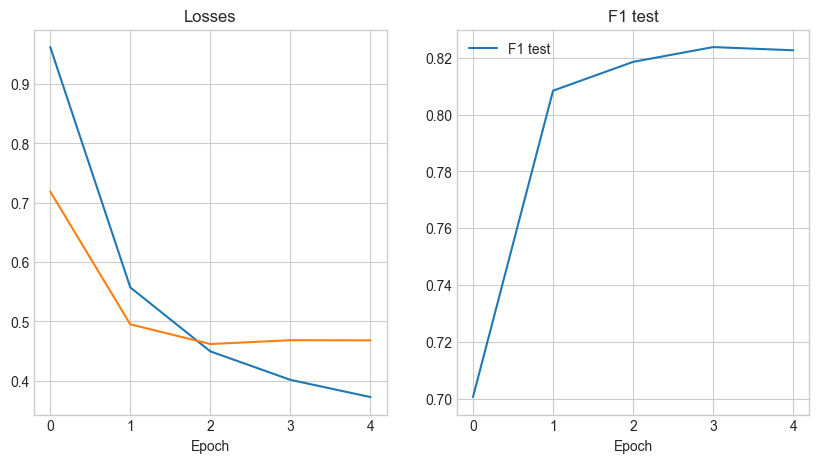

Epoch 5
Losses: train -- 0.5484003606383786, val -- 0.5222482897159529
F1 test: 0.8226337572729924


In [24]:
# Starting training

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters())
epochs = 5

model = model.to(device)

test_targets, test_pred_class = train(
    train_loader, validation_loader, model, optimizer, criterion, epochs
)

In [25]:
# We have got decent f1 with only 5 epochs with a bit of overfitting


In [26]:
class_rep = classification_report(test_targets, test_pred_class)
print(class_rep)


              precision    recall  f1-score   support

           0       0.80      0.87      0.84      1096
           1       0.85      0.74      0.79       728
           2       0.84      0.84      0.84       776

    accuracy                           0.83      2600
   macro avg       0.83      0.82      0.82      2600
weighted avg       0.83      0.83      0.82      2600



In [27]:
# Let's compare with the the largest BERT model 

In [28]:
from transformers import (
    BertForSequenceClassification,
    BertTokenizer,
    TrainingArguments,
    Trainer,
)

In [29]:
test_model = BertForSequenceClassification.from_pretrained("models/fine_tune_v1").to(
    device
)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [30]:
test_preds = []
test_labels = []


In [31]:
for x, y in zip(x_val, y_val):
    inputs = tokenizer(
        x, padding="max_length", truncation=True, return_tensors="pt"
    ).to(device)
    logits = test_model(**inputs).logits
    ouputs = logits.argmax().item()
    test_preds.append(ouputs)
    test_labels.append(y)

In [32]:
bert_class_rep = classification_report(test_labels, test_preds)
print(bert_class_rep)


              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1096
           1       0.88      0.89      0.89       728
           2       0.89      0.90      0.90       776

    accuracy                           0.89      2600
   macro avg       0.89      0.89      0.89      2600
weighted avg       0.89      0.89      0.89      2600



In [33]:
# And with the best-score ruBERT model

In [39]:
test_model = BertForSequenceClassification.from_pretrained("models/rubert_fine_tune/v1").to(
    device
)
tokenizer = BertTokenizer.from_pretrained("cointegrated/rubert-tiny2")

In [40]:
test_preds = []
test_labels = []

In [41]:
for x, y in zip(x_val, y_val):
    inputs = tokenizer(
        x, padding="max_length", truncation=True, return_tensors="pt"
    ).to(device)
    logits = test_model(**inputs).logits
    ouputs = logits.argmax().item()
    test_preds.append(ouputs)
    test_labels.append(y)

In [43]:
bert_class_rep = classification_report(test_labels, test_preds)
print(bert_class_rep)


              precision    recall  f1-score   support

           0       0.96      0.92      0.94      1096
           1       0.92      0.95      0.93       728
           2       0.94      0.97      0.95       776

    accuracy                           0.94      2600
   macro avg       0.94      0.94      0.94      2600
weighted avg       0.94      0.94      0.94      2600



In [44]:
# We got a slightly less good result, but a much lighter model